## Abstract

The aim of this blog post is to develop a classification model, trained on the Palmer Penguins dataset, that is capable of predicting the species (Gentoo, Adelie, or Chinstrap) of an unknown penguin. In the process, the goal is to refine skills of feature selection, model fitting, and model testing. This includes creating repeatable and exhaustive feature selection processes, using both testing and training data sets, and analyzing the resulting model for potential underlying issues. The goal is to identify a model with 100% accuracy on the training data at identifying the species of a penguin based on two quantitative and one qualitative predictor feature. A Random Forest Classifier, using Clutch Completion (Yes/No), Culmen Length, and Culmen Depth as predictor variables, yielded a 100% accuracy when tested.

## Setting Up the Data

Import pandas, and the data for training:

In [124]:
import pandas as pd

train_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
  df = df[df["Sex"] != "."]
  df = df.dropna()
  y = le.transform(df["Species"])
  df = df.drop(["Species"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

X_train, y_train = prepare_data(train)

## Let's Explore the data:

This is what the data looks like:

In [125]:
train["Species"] = train["Species"].str.split().str.get(0)

train.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0809,31,Chinstrap,Anvers,Dream,"Adult, 1 Egg Stage",N63A1,Yes,11/24/08,40.9,16.6,187.0,3200.0,FEMALE,9.08458,-24.54903,NaN
1,PAL0809,41,Chinstrap,Anvers,Dream,"Adult, 1 Egg Stage",N74A1,Yes,11/24/08,49.0,19.5,210.0,3950.0,MALE,9.53262,-24.66867,NaN
2,PAL0708,4,Gentoo,Anvers,Biscoe,"Adult, 1 Egg Stage",N32A2,Yes,11/27/07,50.0,15.2,218.0,5700.0,MALE,8.25540,-25.40075,NaN
3,PAL0708,15,Gentoo,Anvers,Biscoe,"Adult, 1 Egg Stage",N38A1,Yes,12/3/07,45.8,14.6,210.0,4200.0,FEMALE,7.79958,-25.62618,NaN
4,PAL0809,34,Chinstrap,Anvers,Dream,"Adult, 1 Egg Stage",N65A2,Yes,11/24/08,51.0,18.8,203.0,4100.0,MALE,9.23196,-24.17282,NaN


Lets group our data by Species and Clutch completion, and look at the mean and standard deviation for the quantitative columns. In doing so, we should be able to see some columns that might be useful for differentiating species. 

In [126]:
table = train.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1).groupby(['Clutch Completion', 'Species']).aggregate(['mean', 'std'])
table.head()

Culmen Length (mm)           Culmen Depth (mm)  \
                                          mean       std              mean   
Clutch Completion Species                                                    
No                Adelie             39.041667  2.152571         18.225000   
                  Chinstrap          49.040000  4.627022         18.040000   
                  Gentoo             46.485714  3.632001         14.714286   
Yes               Adelie             38.962617  2.698411         18.429907   
                  Chinstrap          48.780851  3.207982         18.436170   

                                      Flipper Length (mm)            \
                                  std                mean       std   
Clutch Completion Species                                             
No                Adelie     1.072063          187.666667  7.726381   
                  Chinstrap  0.987927          194.400000  7.121173   
                  Gentoo     1.206135          216.000000  6.708204   
Yes               Adelie     1.235040          190.355140  6.549164   
                  Chinstrap  1.165151          196.340426  7.516002   

                            Body Mass (g)             Delta 15 N (o/oo)  \
                                     mean         std              mean   
Clutch Completion Species                                                 
No                Adelie      3764.583333  605.604350          8.913195   
                  Chinstrap   3532.500000  536.196740          9.425587   
                  Gentoo      4910.714286  679.131974          8.279576   
Yes               Adelie      3713.317757  447.165045          8.856116   
                  Chinstrap   3788.297872  366.195595          9.310443   

                                      Delta 13 C (o/oo)            
                                  std              mean       std  
Clutch Completion Species                                          
No                Adelie     0.328239        -25.676738  0.485634  
                  Chinstrap  0.346548        -24.560953  0.320757  
                  Gentoo     0.235220        -26.247917  0.577585  
Yes               Adelie     0.436348        -25.810248  0.578651  
                  Chinstrap  0.375693        -24.551794  0.230540

This is helpful, but it might be even more insightful and intuitive to compute the range of 2 standard deviations for each quantitative column. With the standard deviations and means calculated, the range of 2 standard deviations can then be calculated by subtracting and adding 2 times the value of the std dev to/from the mean for that column.

Note: I found the assign function used below in search of a pandas equivalent of the R mutate()function (See link below)

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.assign.html



In [127]:

table = table.assign(Culmen_Length_Max = table["Culmen Length (mm)"]["mean"] + 2*table["Culmen Length (mm)"]["std"], Culmen_Length_Min = table["Culmen Length (mm)"]["mean"] - 2*table["Culmen Length (mm)"]["std"])
table = table.assign(Culmen_Depth_Max = table["Culmen Depth (mm)"]["mean"] + 2*table["Culmen Depth (mm)"]["std"], Culmen_Depth_Min = table["Culmen Depth (mm)"]["mean"] - 2*table["Culmen Depth (mm)"]["std"])
table = table.assign(Body_Mass_Max = table["Body Mass (g)"]["mean"] + 2*table["Body Mass (g)"]["std"], Body_Mass_Min = table["Body Mass (g)"]["mean"] - 2*table["Body Mass (g)"]["std"])
table = table.assign(Flipper_Length_Max = table["Flipper Length (mm)"]["mean"] + 2*table["Flipper Length (mm)"]["std"], Flipper_Length_Min = table["Flipper Length (mm)"]["mean"] - 2*table["Flipper Length (mm)"]["std"])
table = table.assign(Delta_13_Max = table["Delta 13 C (o/oo)"]["mean"] + 2*table["Delta 13 C (o/oo)"]["std"], Delta_13_Min = table["Delta 13 C (o/oo)"]["mean"] - 2*table["Delta 13 C (o/oo)"]["std"])
table = table.assign(Delta_15_Max = table["Delta 15 N (o/oo)"]["mean"] + 2*table["Delta 15 N (o/oo)"]["std"], Delta_15_Min = table["Delta 15 N (o/oo)"]["mean"] - 2*table["Delta 15 N (o/oo)"]["std"])
table.drop(["Culmen Length (mm)", "Culmen Depth (mm)", "Body Mass (g)", "Flipper Length (mm)", "Delta 15 N (o/oo)", "Delta 13 C (o/oo)"], axis = 1)

Culmen_Length_Max Culmen_Length_Min  \
                                                                  
Clutch Completion Species                                         
No                Adelie            43.346808         34.736525   
                  Chinstrap         58.294044         39.785956   
                  Gentoo            53.749716         39.221713   
Yes               Adelie            44.359438         33.565796   
                  Chinstrap         55.196815         42.364888   
                  Gentoo            52.472111         41.765667   

                            Culmen_Depth_Max Culmen_Depth_Min Body_Mass_Max  \
                                                                              
Clutch Completion Species                                                     
No                Adelie           20.369125        16.080875   4975.792033   
                  Chinstrap        20.015854        16.064146   4604.893481   
                  Gentoo           17.126556        12.302015   6268.978234   
Yes               Adelie           20.899986        15.959827   4607.647847   
                  Chinstrap        20.766472        16.105869   4520.689062   
                  Gentoo           16.914536        12.945464   6021.446275   

                            Body_Mass_Min Flipper_Length_Max  \
                                                               
Clutch Completion Species                                      
No                Adelie      2553.374633         203.119429   
                  Chinstrap   2460.106519         208.642347   
                  Gentoo      3552.450338         229.416408   
Yes               Adelie      2818.987667         203.453469   
                  Chinstrap   3055.906683         211.372430   
                  Gentoo      4078.553725         228.625764   

                            Flipper_Length_Min Delta_13_Max Delta_13_Min  \
                                                                           
Clutch Completion Species                                                  
No                Adelie            172.213904   -24.705470   -26.648007   
                  Chinstrap         180.157653   -23.919438   -25.202468   
                  Gentoo            202.583592   -25.092747   -27.403087   
Yes               Adelie            177.256812   -24.652947   -26.967550   
                  Chinstrap         181.308421   -24.090715   -25.012873   
                  Gentoo            204.996458   -25.027738   -27.255542   

                            Delta_15_Max Delta_15_Min  
                                                       
Clutch Completion Species                              
No                Adelie        9.569673     8.256716  
                  Chinstrap    10.118684     8.732490  
                  Gentoo        8.750016     7.809135  
Yes               Adelie        9.728812     7.983420  
                  Chinstrap    10.061828     8.559058  
                  Gentoo        8.810899     7.678713

 This is extraordinarily insightful, as we can see which quantitative columns have distinct ranges when grouped by Culmen Depth and Species. Since 95.4% of data falls within 2 std deviations of the mean, distinct ranges in this category can help identify very high quality candidate columns to use as quantitative predictor variables. 

Upon analysis of this table, the Culmen Length, Culmen Depth, and Flipper Length appear to the columns with the most variation in ranges across species and Clutch Completion. For penguins with a clutch completion of No, Culmen Length ranges are potentially distinguishable for Adelie compared with Chinstrap and Gentoo, Culmen Depth ranges are distinguishable for Gentoo compared with Adelie and Chinstrap, and Flipper Length has all overlapping ranges although they are also very different with Adelie the low end, Chinstrap in the middle, and Gentoo at the top.

For penguins with clutch completion of yes, Culmen Length distinguishes Adelie from Chinstrap and Gentoo, Culmen Depth distinguishes Gentoo from Adelie and Chinstrap, and Flipper Length once again are overlapping but not completely. 

Let's make visualizations of these differences to analyze them further.


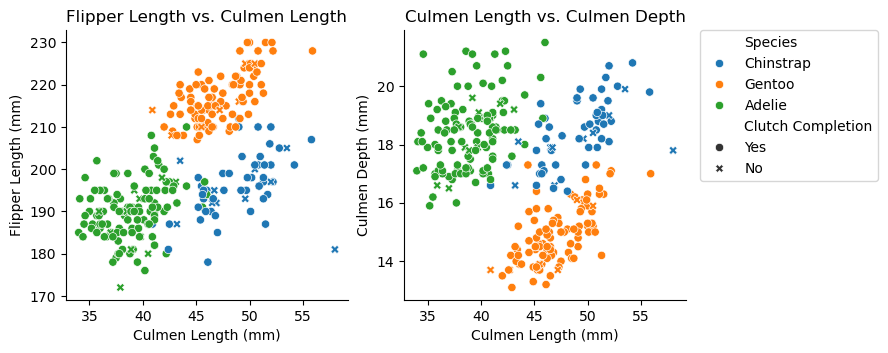

In [128]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize = (8, 3.5))

# p1 = sns.scatterplot(train, x = "Flipper Length (mm)", y = "Culmen Length (mm)",  style = "Island", hue = "Species")
p1 = sns.scatterplot(train, x = "Culmen Length (mm)", y = "Culmen Depth (mm)", ax = ax[1],  style = "Clutch Completion", hue = "Species")

sns.despine() # remove the top and right spines

p1.title.set_text("Culmen Length vs. Culmen Depth")


p2 = sns.scatterplot(train, x = "Culmen Length (mm)", y = "Flipper Length (mm)", ax = ax[0],  style = "Clutch Completion", hue = "Species")

p2.title.set_text("Flipper Length vs. Culmen Length") # set the title of the left visualization
ax[0].get_legend().remove() # remove the legend from the left graph to avoid duplication and messiness


plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.) # move the legend to the right graph




From these two Plots, it appears that while Flipper Length and Culmen Depth would be very useful for distinguishing Gentoo penguins from the other two species, it would be very difficult to distinguish between the Chinstrap and Adelie penguins. When replacing Flipper Length with Culmen Depth, it appears that while the overlap still exists it may be possible to develop an appropriate model for predicting species. 

Regardless, the most important takeaway is that it seems inlikely by looking at the data that a logistic regression will be capable of achieving 100% accuracy using these features, as there are some overlapping—or close to overlapping—regions on both of these graphs. 

## Choosing Features

Now that we have explored the data and established that a model may be effective and developed some hypothesis regarding which features and models might work best, we need to do an exhaustive and repeatable feature search to ensure that we create the best possible model.

#### Logistic Regression

First, let's try using a Logistic Regression even though our visualizations suggested this might not be 100% effective.

In this code we cycle through all combinations of 1 qualitative and 2 quantitative predictor features, saving the score and feature set that perform the best.

In [129]:
from itertools import combinations
from sklearn.linear_model import LogisticRegression


all_qual_cols = ["Clutch Completion", "Sex", "Island"]
all_quant_cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', "Body Mass (g)", "Delta 15 N (o/oo)", "Delta 13 C (o/oo)"]
best_score = 0
best_cols = []

for qual in all_qual_cols: 
  qual_cols = [col for col in X_train.columns if qual in col ]
  for pair in combinations(all_quant_cols, 2):
    cols = qual_cols + list(pair) 
    LR = LogisticRegression(max_iter = 10000)
    LR.fit(X_train[cols], y_train)
    new_score = LR.score(X_train[cols], y_train)
    if new_score > best_score:
      best_score = new_score
      best_cols = cols  




print("Highest Scoring Columns: ", best_cols)
print("Highest Score: ", best_score)

Highest Scoring Columns:  ['Sex_FEMALE', 'Sex_MALE', 'Culmen Length (mm)', 'Culmen Depth (mm)']
Highest Score:  0.99609375


Using a Logistic Regression, the highest score we find is 0.996 using Sex, Culmen Length, and Culmen depth. Because our aim is 100%, there is no logistic regression using 1 qualitative and 2 quantitative predictor features that will achieve our goal. let's take a look at using a different model

#### Random Forest Classifier

The same process is followed as above, except the Logistic Regression is substituted for a Random Forrest Classifier.

In [130]:
from itertools import combinations
from sklearn.ensemble import RandomForestClassifier

all_qual_cols = ["Clutch Completion", "Sex", "Island"]
all_quant_cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', "Body Mass (g)", "Delta 15 N (o/oo)", "Delta 13 C (o/oo)"]
best_score = 0
best_cols = []

for qual in all_qual_cols: 
  qual_cols = [col for col in X_train.columns if qual in col ]
  for pair in combinations(all_quant_cols, 2):
    cols = qual_cols + list(pair) 
    RF = RandomForestClassifier()
    RF.fit(X_train[cols], y_train)
    new_score = RF.score(X_train[cols], y_train)
    if new_score > best_score:
      best_score = new_score
      best_cols = cols  




print("Highest Scoring Columns: ", best_cols)
print("Highest Score: ", best_score)

Highest Scoring Columns:  ['Clutch Completion_No', 'Clutch Completion_Yes', 'Culmen Length (mm)', 'Culmen Depth (mm)']
Highest Score:  1.0


Wonderful! Our search has found that using a Random Forest Classifier, CLutch Completion, Culmen Length, and Culmen Depth results in a perfect score when scored on the training data. Now we need to fit the model with the best columns found above.

## Fitting the Model — Random Forest Classifier Model
Since we have identified that the Random Forest Classifier model has a score of 1 with the columns of Clutch Completion, Culmen Length, and Culmen depth, let's train our model: 

In [131]:
RF = RandomForestClassifier()
RF.fit(X_train[["Culmen Length (mm)", "Culmen Depth (mm)", "Clutch Completion_No", "Clutch Completion_Yes"]], y_train)

RandomForestClassifier()

#### Cross Validation
Before Committing to the Random Forest Classifier Model, let's cross validate it!

In [132]:
from sklearn.model_selection import cross_val_score
cv_scores_RF = cross_val_score(RF, X_train, y_train, cv=5)
cv_scores_RF

array([0.98076923, 1.        , 1.        , 0.98039216, 1.        ])

3 / 5 of our folds score perfectly in cross validation. This suggests that there are specific values in our dataset that are difficult to classify if they are in the testing data and not in the training data, but also that our model is performing very well.

Let's look at the mean score:

In [133]:
cv_scores_RF.mean()

0.9922322775263952

This gives us a mean score of .99, very close to our goal of 1. With this in mind, let's test the data to see how we did. 

## Testing — Random Forest Classifier Model

With our model trained, we can now import the test data and see how our model performs.

In [134]:
test_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)

X_test, y_test = prepare_data(test)
RF.score(X_test[["Culmen Length (mm)", "Culmen Depth (mm)", "Clutch Completion_No", "Clutch Completion_Yes"]], y_test)



1.0

In [135]:
from sklearn.metrics import confusion_matrix

y_test_pred = RF.predict(X_test[["Culmen Length (mm)", "Culmen Depth (mm)", "Clutch Completion_No", "Clutch Completion_Yes"]])
C = confusion_matrix(y_test, y_test_pred)
for i in range(3):
    for j in range(3):
        print(f"There were {C[i,j]} {le.classes_[i]} penguin(s) who were classified as {le.classes_[j]}.")

There were 31 Adelie Penguin (Pygoscelis adeliae) penguin(s) who were classified as Adelie Penguin (Pygoscelis adeliae).
There were 0 Adelie Penguin (Pygoscelis adeliae) penguin(s) who were classified as Chinstrap penguin (Pygoscelis antarctica).
There were 0 Adelie Penguin (Pygoscelis adeliae) penguin(s) who were classified as Gentoo penguin (Pygoscelis papua).
There were 0 Chinstrap penguin (Pygoscelis antarctica) penguin(s) who were classified as Adelie Penguin (Pygoscelis adeliae).
There were 11 Chinstrap penguin (Pygoscelis antarctica) penguin(s) who were classified as Chinstrap penguin (Pygoscelis antarctica).
There were 0 Chinstrap penguin (Pygoscelis antarctica) penguin(s) who were classified as Gentoo penguin (Pygoscelis papua).
There were 0 Gentoo penguin (Pygoscelis papua) penguin(s) who were classified as Adelie Penguin (Pygoscelis adeliae).
There were 0 Gentoo penguin (Pygoscelis papua) penguin(s) who were classified as Chinstrap penguin (Pygoscelis antarctica).
There were

Our model predicted the species of the test data set with 100% accuracy! Yay! As such, our confusion matrix tells us that every penguin was predicted to be the species that it actually belongs to.

## Plotting Decision regions:

The code below is code for plotting data points on top of the decision regions of a given model:

In [136]:
from matplotlib import pyplot as plt
import numpy as np

from matplotlib.patches import Patch

def plot_regions(model, X, y):
    
    x0 = X[X.columns[0]]
    x1 = X[X.columns[1]]
    qual_features = X.columns[2:]
    
    fig, axarr = plt.subplots(1, len(qual_features), figsize = (7, 3))

    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    XX = xx.ravel()
    YY = yy.ravel()

    for i in range(len(qual_features)):
      XY = pd.DataFrame({
          X.columns[0] : XX,
          X.columns[1] : YY
      })

      for j in qual_features:
        XY[j] = 0

      XY[qual_features[i]] = 1

      p = model.predict(XY)
      p = p.reshape(xx.shape)
      
      
      # use contour plot to visualize the predictions
      axarr[i].contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
      
      ix = X[qual_features[i]] == 1
      # plot the data
      axarr[i].scatter(x0[ix], x1[ix], c = y[ix], cmap = "jet", vmin = 0, vmax = 2)
      
      axarr[i].set(xlabel = X.columns[0], 
            ylabel  = X.columns[1], 
            title = qual_features[i])
      
      patches = []
      for color, spec in zip(["red", "green", "blue"], ["Adelie", "Chinstrap", "Gentoo"]):
        patches.append(Patch(color = color, label = spec))

      plt.legend(title = "Species", bbox_to_anchor=(1.05, 1), handles = patches, loc='upper left', borderaxespad=0.)

      
      
      plt.tight_layout()

With this function, we can now pass in our data and model.

#### Training Data and Classification Regions
Lets start with the decision regions plotted with the training data. This is insightful for seeing how the model was fit around our training dataset.

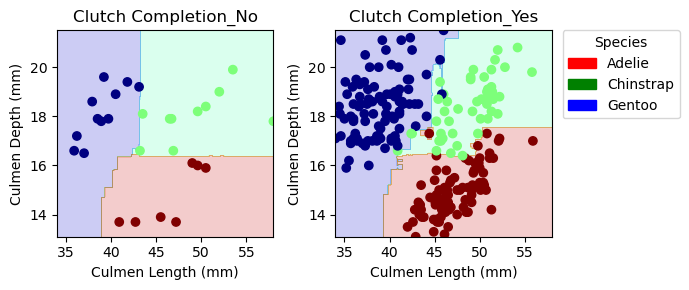

In [137]:
plot_regions(RF, X_train[["Culmen Length (mm)", "Culmen Depth (mm)", "Clutch Completion_No", "Clutch Completion_Yes"]], y_train)


It is interesting to note that this is potentially an overfit. Notice the distinct Adelie region in the Clutch Completion = Yes visualization or the sliver of Gentoo reaching into the Chinstrap region. Let's take a look at how these did not end up being a problem in the prediction of our testing data species. These are likely the exact points that were causing certain cross validations to be worse than others.

#### Testing Data and Classification Regions

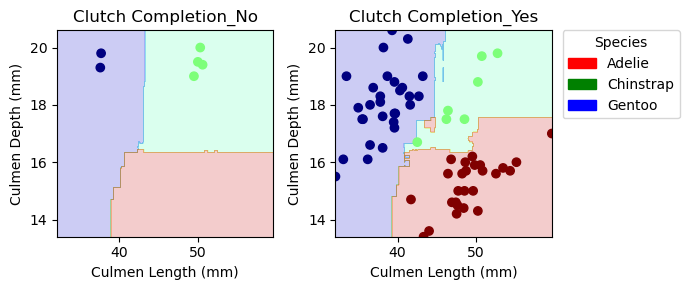

In [138]:
plot_regions(RF, X_test[["Culmen Length (mm)", "Culmen Depth (mm)", "Clutch Completion_No", "Clutch Completion_Yes"]], y_test)

We can see from these visualizations that this testing data has much less overlap than our training dataset—it does not have many of those "problematic" points seen in the training data. I would be interested to see if this model would hold up on a much larger testing dataset, or if we had been given a different split for test/train. It is also important to note that the testing dataset had very little data with no for clutch completion, and none in that category that were Adelie. 

## Discussion

#### Process and Results

It was found that it is possible to train a model, using the palmer penguins data set, that is capable of predicting the target value—species—with perfect accuracy. This was achieved through the use of a Random Forrest Classifier model, 3 predictor variables: Clutch Completion, Culmen Length, and Culmen Depth. While a Logistic Regression was attempted, our goal of a perfect prediction score could not be achieved using a Logistic Regression and any combination of 2 quantitative and 1 qualitative predictor variables. It should also be noted that there were particular points in the training dataset that were potentially overfit by our successful Random Forest Classification model. This was observed in cross validation, in which only 3/5 of our splits achieved a perfect score. It was also observed visually in the display of the training data plotted on top of the model's decision regions. This did not materialize as a poor score in the final testing, because the data in the testing dataset coincidentally did not have many points in the regions where the potential overfitting occurred. A larger dataset, or a different train test split, would be interesting next steps to see if our model selection and feature selection were good ones.

#### Learning

Apart from enhancing my technical skills for exploring a dataset, performing a train test split, creating a repeatable methodology for feature selection, and fitting and testing a model, this process taught me a lot about the potential problems that can come with classification models. Particularly, the limits on logistic regressions in classification, the potential for overfitting, and the importance of having enough varied data in both your training and testing data. I also learned how helpful visualizations can be for understanding what is going on throughout the model creation process. 




